In [35]:
using LinearAlgebra
using Plots
function func_deriv(func, x, eps=1.e-6)
    __sz = length(x)
    result = zeros(__sz)
    for i in 1:__sz
        next_x = copy(x)
        next_x[i] += eps
        result[i] = (func(next_x) - func(x)) / eps
    end
    return result
end
function func_hess(func, x, eps=1.e-6)
    __sz = length(x)
    result = zeros(__sz, __sz)
    for i in 1:__sz
        next_x = copy(x)
        next_x[i] += eps
        result[i,:] = (func_deriv(func, next_x) - func_deriv(func, x)) / eps
    end
    return result
end

function min_search(f, a::Float64, b::Float64, eps= 1e-6)
    while(b-a > eps)
        delta = (b-a)/4
        f1 = f(a + delta)
        f2 = f(b - delta)
        if f1 < f2
            b = b - delta
        else
            a = a + delta
        end
    end
    return (b + a)/2
end

function bissect(f, a::Float64, b::Float64, eps=1e-6)
    while(b-a > eps)
        mid = (a + b) / 2
        if f(a) > f(mid)
            a = mid
        else
            b = mid
        end
    end
    return (b + a)/2
end

bissect (generic function with 2 methods)

In [84]:
target_func(x) = 3*(x[1]-5)^2 + 7*(x[2]-10)^2
#target_func(x) = (2*x[1] - 5*x[2])^2 + (x[2] + 6)^2
target_func_deriv(x) = func_deriv(target_func, x)
target_func_hess(x) = func_hess(target_func_deriv, x)

target_func_hess (generic function with 1 method)

In [38]:
function NewtonMethod(func, x0, eps=1.e-6, max_iter=1000)
    x = x0
    iterations = 0
    path = [x0]
    for idx in 1:max_iter
        iterations+=1
        grad = func_deriv(func, x)
        hessian = func_hess(func, x)
        x -= inv(hessian) * grad
        push!(path, x)
        if norm(func_deriv(func, x)) < eps
            break
        end
    end
    return x, func(x), iterations, path
end

NewtonMethod (generic function with 3 methods)

In [39]:
function NewtonMethodWithLinearOpt(func, x0, eps=1.e-6, max_iter=1000)
    x = x0
    iterations = 0
    path = [x0]
    
    for idx in 1:max_iter
        iterations += 1
        grad = func_deriv(func, x)
        hessian = func_hess(func, x)
        g(alpha) = func(x - alpha*inv(hessian)*grad)
        alpha_min = bissect(g, 0.0, 100.0)
        #alpha_min = min_search(g, 0.0, 100.0, 1.e-8)
        x -= alpha_min * inv(hessian) * grad
        push!(path, x)
        if norm(func_deriv(func, x)) < eps
            break
        end
    end
    return x, func(x), iterations, path
end

NewtonMethodWithLinearOpt (generic function with 3 methods)

In [40]:
function NewtonMethodWithStaticHess(func, x0, eps=1.e-6, max_iter=1000)
    x = x0
    H = inv(func_hess(func, x0))
    iterations = 0
    path = [x0]
    for idx in 1:max_iter
        iterations += 1
        grad = func_deriv(func, x)
        g(alpha) = func(x - alpha*H*grad)
        alpha_min = bissect(g, 0.0, 100.0)
        x -= alpha_min * H * grad
        push!(path, x)
        if norm(func_deriv(func, x)) < eps
            break
        end
    end
    return x, func(x), iterations, path
end

NewtonMethodWithStaticHess (generic function with 3 methods)

In [85]:
function square_approx(x0, x1, x2, y0, y1, y2)
    a0 = y0
    a1 = (y1 - y0) / (x1 - x0)
    a2 = 1 / (x2 - x1) * ((y2 - y0) / (x2 - x0) - (y1 - y0) / (x1 - x0)) 
    return (x1 + x0) / 2 - a1 / (2 * a2)
end

function Powell(func, x0, eps=1e-6, max_iter = 100, deltas=[0.1,0.1])
    x = [x0, copy(x0), copy(x0)]
    y = [0.0, 0.0, 0.0]
    x_opt = copy(x0)
    x_min = copy(x0)
    iterations = 0
    path = [x0]
    for idx in 1:max_iter
        best_x = x[1]
        for cord in 1:length(x0)
            x_opt = copy(x[1])
            x[2][cord] = x[1][cord] + deltas[cord]
            y[1] = func(x[1])   
            y[2] = func(x[2])
            if y[1] > y[2]
                x[3][cord] = x[1][cord] + 2 * deltas[cord]
            else
                x[3][cord] = x[1][cord] - deltas[cord]
            end
            y[3] = func(x[3])
            x_opt[cord] = square_approx(x[1][cord], x[2][cord], x[3][cord], y[1], y[2], y[3])
            y_min_idx = argmin(y)
            x_min = x[y_min_idx]
            push!(path, best_x)
            if func(x_min) < func(x_opt)
                best_x = x_min    
            else
                best_x = x_opt
            end
            x = [copy(best_x), copy(best_x), copy(best_x)]
        end
        iterations += 1
        if norm(x_opt - x_min) < eps
            break
        end 
    end
    
    return x_min, func(x_min), iterations, path
end

Powell (generic function with 4 methods)

In [88]:
x0 = [0.0, 0.0]
result1 = NewtonMethod(target_func, x0)
result2 = NewtonMethodWithLinearOpt(target_func, x0, 1.e-6, 100)
result3 = NewtonMethodWithStaticHess(target_func, x0, 1.e-6, 100)
result4 = Powell(target_func, x0, 1.e-6, 100)

([5.0, 9.999999999992855], 3.5730788272293e-22, 2, [[0.0, 0.0], [0.0, 0.0], [4.999999999995168, 0.0], [4.999999999995168, 9.999999999992855], [5.0, 9.999999999992855]])

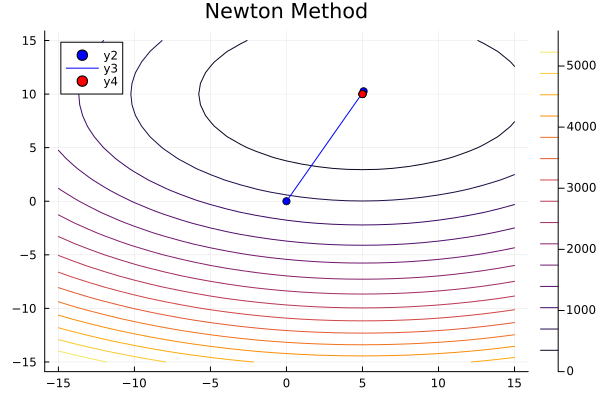

In [53]:
px_1 = [result1[4][i][1] for i in 1:length(result1[4])]
py_1 = [result1[4][i][2] for i in 1:length(result1[4])]
x = y = -15:1:15;
plot(x, y, (x,y)->target_func([x,y]), st = :contour, title="Newton Method")
plot!(px_1, py_1, seriestype=:scatter, color = "blue")
plot!(px_1, py_1, color = "blue")
plot!([result1[1][1]], [result1[1][2]], seriestype=:scatter, color = "red")

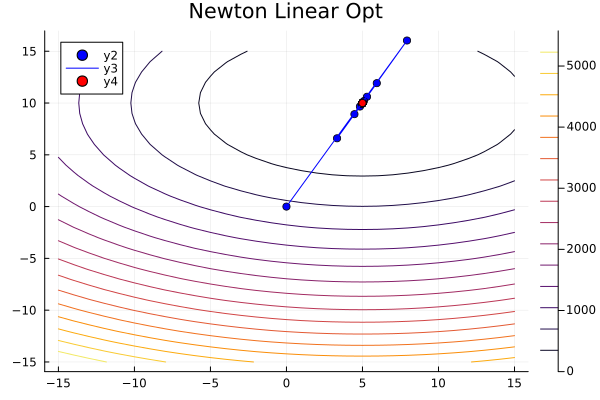

In [52]:
px_2 = [result2[4][i][1] for i in 1:length(result2[4])]
py_2 = [result2[4][i][2] for i in 1:length(result2[4])]
x = y = -15:1:15;
plot(x, y, (x,y)->target_func([x,y]), st = :contour, title="Newton Linear Opt")
plot!(px_2, py_2, seriestype=:scatter, color = "blue")
plot!(px_2, py_2, color = "blue")
plot!([result2[1][1]], [result2[1][2]], seriestype=:scatter, color = "red")

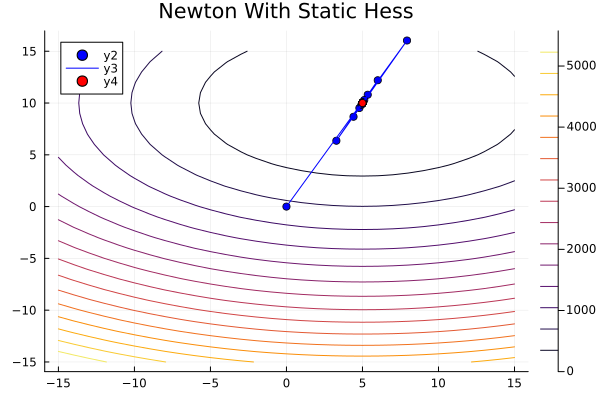

In [51]:
px_3 = [result3[4][i][1] for i in 1:length(result3[4])]
py_3 = [result3[4][i][2] for i in 1:length(result3[4])]
x = y = -15:1:15;
plot(x, y, (x,y)->target_func([x,y]), st = :contour)
plot!(px_3, py_3, seriestype=:scatter, color = "blue", title="Newton With Static Hess")
plot!(px_3, py_3, color = "blue")
plot!([result3[1][1]], [result3[1][2]], seriestype=:scatter, color = "red")

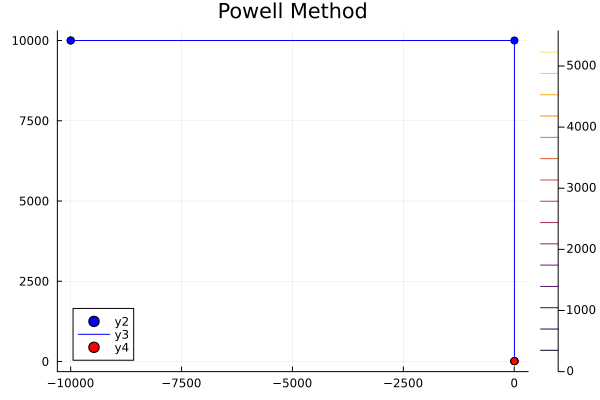

In [87]:
px_4 = [result4[4][i][1] for i in 1:length(result4[4])]
py_4 = [result4[4][i][2] for i in 1:length(result4[4])]
x = y = -15:1:15;
plot(x, y, (x,y)->target_func([x,y]), st = :contour)
plot!(px_4, py_4, seriestype=:scatter, color = "blue", title="Powell Method")
plot!(px_4, py_4, color = "blue")
plot!([result4[1][1]], [result4[1][2]], seriestype=:scatter, color = "red")